## 📊 IT24100258 Customer Filtering

**Objective**: Remove noise customers with very low engagement to improve clustering quality

### Key Implementation:
- **Filter Criteria**: `Frequency > 1 AND Monetary > 0`
- **Input**: `05_rfm_scaled.csv` (transformed & scaled RFM data)
- **Output**: `06_filtered_customers_enhanced.csv` (clean dataset ready for clustering)

### Results:
- Applied strict filtering to remove one-time buyers and zero-spend customers
- Enhanced dataset with customer value segmentation
- Generated comprehensive EDA visualizations for filtering analysis

### EDA Visualizations:
1. **Customer filtering results comparison** - Bar chart showing kept vs removed customers
2. **Frequency distribution comparison** - Before/after filtering histograms

- **Output**: High-quality customer dataset optimized for clustering algorithms
- **Impact**: Improved data quality by removing noise customers for better segmentation results

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
csv_path = "../results/outputs/05_rfm_scaled.csv"
PLOTS = Path("../results/eda_visualization")
OUTS = Path("../results/outputs")

In [3]:
#function to save the image files in eda_visualization folder
def save_fig(name):
    out = PLOTS / f"{"IT24100258_Pasan"}_{name}.png"
    plt.tight_layout()
    plt.savefig(out, dpi=200, bbox_inches="tight")
    plt.show()
    plt.close()
    print(f"Saved: {out}")

In [4]:
# Load the scaled RFM dataset
df = pd.read_csv(csv_path)
print("Loaded RFM data shape:", df.shape)
print("Columns:", df.columns.tolist())
print(f"\nSuccess! Loaded {len(df.columns)} columns.")
print("Data includes original R,F,M + scaled features")

Loaded RFM data shape: (5881, 7)
Columns: ['customer_id', 'R', 'F', 'M', 'R_scaled', 'F_scaled', 'M_scaled']

Success! Loaded 7 columns.
Data includes original R,F,M + scaled features


In [6]:
# Check the data structure
print("RFM data info:")
df.info()
print("\nSample of data:")
print("- Original features: R, F, M")
print("- Scaled features: R_scaled, F_scaled, M_scaled")
df_rfm = df.set_index("customer_id")

RFM data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  5881 non-null   int64  
 1   R            5881 non-null   int64  
 2   F            5881 non-null   int64  
 3   M            5881 non-null   float64
 4   R_scaled     5881 non-null   float64
 5   F_scaled     5881 non-null   float64
 6   M_scaled     5881 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 321.7 KB

Sample of data:
- Original features: R, F, M
- Scaled features: R_scaled, F_scaled, M_scaled


In [7]:
# Check for customers with F=1 or M=0
print(f"\nCustomers needing filtering:")
print(f"- Customers with F=1: {(df_rfm["F"] == 1).sum():,}")
print(f"- Customers with M=0: {(df_rfm["M"] == 0).sum():,}")
print(f"- Customers with F=1 OR M=0: {((df_rfm["F"] == 1) | (df_rfm["M"] == 0)).sum():,}")
cust = df_rfm.copy()
cust.head()


Customers needing filtering:
- Customers with F=1: 1,625
- Customers with M=0: 3
- Customers with F=1 OR M=0: 1,625


,R,F,M,R_scaled,F_scaled,M_scaled
customer_id,,,,,,
12346,325,12,400.94,0.591999,0.443501,-0.273951
12347,2,8,4585.32,-0.949974,0.134057,0.379317
12348,75,5,1072.23,-0.601479,-0.098027,-0.169149
12349,18,4,4388.34,-0.873592,-0.175388,0.348565
12350,310,1,334.40,0.520390,-0.407471,-0.284339


In [8]:
f_before = cust["F"].copy()
m_before = cust["M"].copy()

filter_condition = (cust["F"] > 1) & (cust["M"] > 0)
cust["Status"] = np.where(filter_condition, "Keep", "Remove")

print("Customer filtering results:")
counts = (
    cust["Status"].value_counts()
    .reindex(["Keep", "Remove"])
    .fillna(0)
    .astype(int)
)
kept, removed = counts["Keep"], counts["Remove"]
total = kept + removed

print(f"- Kept: {kept} ({kept/total*100:.1f}%)")
print(f"- Removed: {removed} ({removed/total*100:.1f}%)")
print(f"- Total: {total}")

Customer filtering results:
- Kept: 4256 (72.4%)
- Removed: 1625 (27.6%)
- Total: 5881


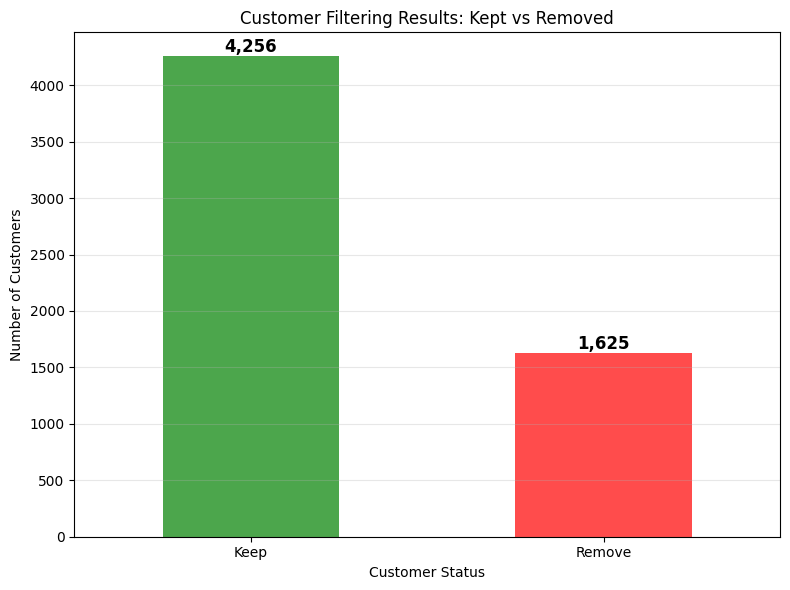

Saved: ..\results\eda_visualization\IT24100258_Pasan_customer_filtering_results.png


In [9]:
# EDA 1: Bar chart of customers removed vs kept
plt.figure(figsize=(8, 6))
ax = counts.plot(
    kind="bar", 
    rot=0, 
    title="Customer Filtering Results: Kept vs Removed",
    color=['green', 'red'],
    alpha=0.7
)

# Add value labels on bars
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height:,}',
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha="center", va="bottom", fontsize=12, fontweight='bold')

plt.xlabel("Customer Status")
plt.ylabel("Number of Customers")
plt.grid(axis='y', alpha=0.3)
save_fig("customer_filtering_results")

In [10]:
# Prepare data for frequency histogram comparison
F_after = cust.loc[filter_condition, "F"]

# Set bins for histogram (ensure meaningful range)
max_f = int(max(f_before.max(), F_after.max())) if len(F_after) > 0 else int(f_before.max())
bins = np.arange(1, min(max_f + 2, 21))  # Limit to 20 for readability

print(f"Frequency range: 1 to {max_f}")
print(f"Customers before filtering: {len(f_before)}")
print(f"Customers after filtering: {len(F_after)}")

Frequency range: 1 to 398
Customers before filtering: 5881
Customers after filtering: 4256


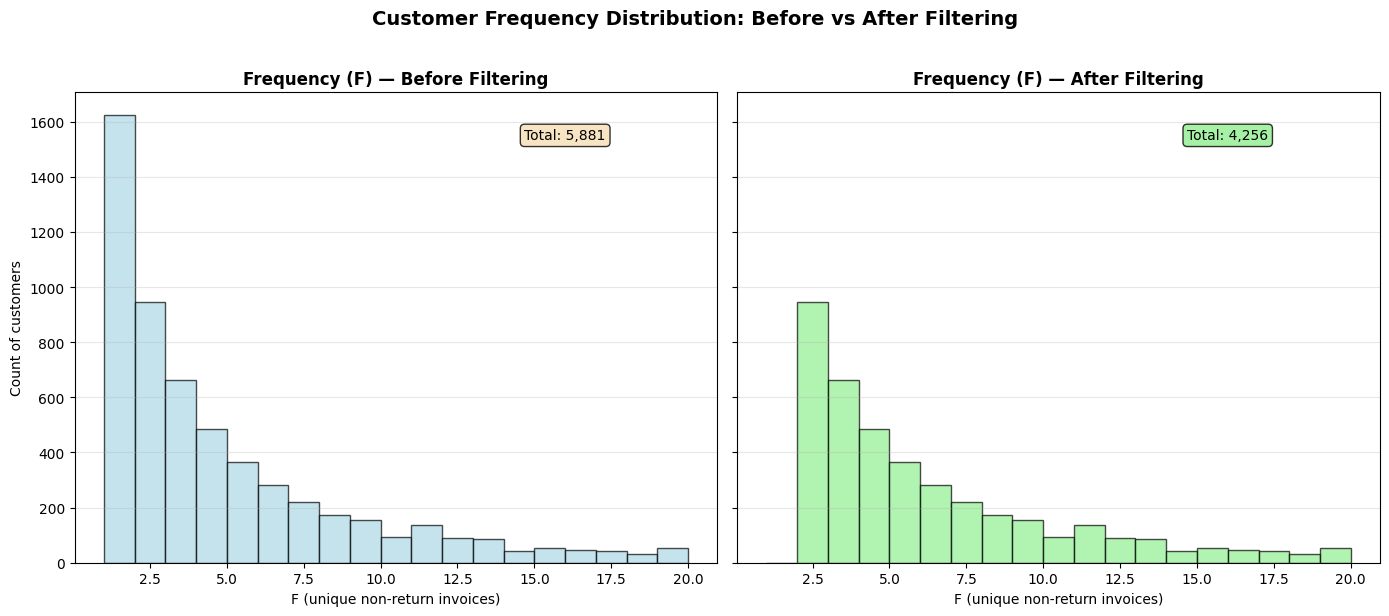

Saved: ..\results\eda_visualization\IT24100258_Pasan_frequency_before_after_filtering.png


In [11]:
# EDA 2: Histogram of Frequency before vs after filtering
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# BEFORE filtering
axes[0].hist(f_before, bins=bins, alpha=0.7, color='lightblue', edgecolor='black')
axes[0].set_title("Frequency (F) — Before Filtering", fontsize=12, fontweight='bold')
axes[0].set_xlabel("F (unique non-return invoices)")
axes[0].set_ylabel("Count of customers")
axes[0].grid(axis='y', alpha=0.3)
axes[0].text(0.7, 0.9, f'Total: {len(f_before):,}', transform=axes[0].transAxes, 
             bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))

# AFTER filtering
axes[1].hist(F_after, bins=bins, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1].set_title("Frequency (F) — After Filtering", fontsize=12, fontweight='bold')
axes[1].set_xlabel("F (unique non-return invoices)")
axes[1].grid(axis='y', alpha=0.3)
axes[1].text(0.7, 0.9, f'Total: {len(F_after):,}', transform=axes[1].transAxes,
             bbox=dict(boxstyle="round", facecolor='lightgreen', alpha=0.8))

fig.suptitle("Customer Frequency Distribution: Before vs After Filtering", 
             y=1.02, fontsize=14, fontweight='bold')
save_fig("frequency_before_after_filtering")

In [12]:
# Save filtered customers with enhanced features for clustering
filtered_customers = cust.loc[filter_condition].copy()
filtered_customers_output = filtered_customers.reset_index()
filtered_customers_output.to_csv(OUTS / "06_filtered_customers_enhanced.csv", index=False)

print(f"\n=== CUSTOMER FILTERING SUMMARY ===")
print(f"Kept: {filter_condition.sum():,} customers ({filter_condition.sum()/len(cust)*100:.1f}%)")
print(f"Removed: {(~filter_condition).sum():,} customers ({(~filter_condition).sum()/len(cust)*100:.1f}%)")
print(f"\nOutput for clustering: 06_filtered_customers_enhanced.csv")
print(f"Features: Original (R,F,M) + Scaled features (ready for clustering)")
print(f"✅ Ready for clustering algorithms")


=== CUSTOMER FILTERING SUMMARY ===
Kept: 4,256 customers (72.4%)
Removed: 1,625 customers (27.6%)

Output for clustering: 06_filtered_customers_enhanced.csv
Features: Original (R,F,M) + Scaled features (ready for clustering)
✅ Ready for clustering algorithms
